## Benchmarking npmine

This notebook is dedicated to illustrate the benchmarking analysis of npmine's three sources of data: oscar, osra and gnfinder. The synthetic pdf was generated with the `generate_pdf` with the input present on _structures_1000_pdfs.json_ file.

In [13]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import AllChem
import numpy as np
import requests
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.backends.backend_svg import svgPages

Matplotlib is building the font cache; this may take a moment.


In [84]:
# Define methods to compare structures recovered by oscar
def mol_similarity(smi1, smi2):
    try:
        ms1 = Chem.MolFromSmiles(smi1)
        ms2 = Chem.MolFromSmiles(smi2)
        #fps1 = Chem.RDKFingerprint(ms1)
        #fps2 = Chem.RDKFingerprint(ms2)
        fps1 = AllChem.GetMorganFingerprint(ms1, 2)
        fps2 = AllChem.GetMorganFingerprint(ms2, 2)
        #return DataStructs.FingerprintSimilarity(fps1, fps2)
        return DataStructs.TanimotoSimilarity(fps1, fps2)
    except:
        return None

def plot_panel(smi, **kwargs):
    ms = [Chem.MolFromSmiles(x) for x  in smi]
    leg = kwargs.get('legends')
    usesvg = kwargs.get('useSVG')
    img = Draw.MolsToGridImage(ms, molsPerRow=2, subImgSize=(200,200), 
                               legends=leg, useSVG=usesvg)
    return img

def score_molecules(ref_list, bench_list, idx):
    ln = len(ref_list)
    comp_list = ln*[[idx, '', '', 0]]
    for i in range(ln):
        fix_scr = 0
        x = ref_list[i]
        for y in bench_list:
            scr = mol_similarity(x, y)
            if scr==None:
                continue
            elif scr==1:
                comp_list[i] = [idx, x, y, scr]
                bench_list.remove(y)
                break
            else:
                if scr > fix_scr:
                    fix_scr = scr
                    comp_list[i] = [idx, x, y, scr]
    return comp_list

In [5]:
# Load the input for pdf simulation for comparison
with open('structures_1000_pdfs.json') as f:
    struct = json.load(f)

len(struct)

1000

In [3]:
# Load npmine results from synthetic pdfs
df = pd.read_csv('entities_img_dataframe.tsv', sep='\t')
df.head()

,doi,smiles,standardInChIKey,ExactMolWt,standardInChI,source
0,final-302.json,NaN,ALIFPGGMJDWMJH-UHFFFAOYSA-N,197.095297,InChI=1S/C12H11N3/c1-3-7-11(8-4-1)13-15-14-12-...,oscar
1,final-302.json,NaN,RDOXTESZEPMUJZ-UHFFFAOYSA-N,108.057515,"InChI=1S/C7H8O/c1-8-7-5-3-2-4-6-7/h2-6H,1H3",oscar
2,final-302.json,NaN,OMYXFRGZYJDEPI-UHFFFAOYSA-N,179.943598,InChI=1S/C4H5I/c1-2-4-5-3-1/h1-5H,oscar
3,final-302.json,NaN,VOQZCIGSIKSGAL-UHFFFAOYSA-N,228.047256,InChI=1S/C12H14Cl2/c1-7-9-3-4-10(9)12(6-14)8(2...,oscar
4,final-302.json,NaN,RYHBNJHYFVUHQT-UHFFFAOYSA-N,88.052429,InChI=1S/C4H8O2/c1-2-6-4-3-5-1/h1-4H2,oscar


In [6]:
# Ground truth's data structure
struct[0]

{'id': 0,
 'structures': ['[C@]123[C@@H]4N(C[C@@H]5[C@H]1CCN(C2)CCCC/C=C\\CCC4=C5)CCCC/C=C\\CC3',
  'Cc1cc2c(c(=O)n1CCc1ccc(c(c1)OC)OC)[C@H](C(=C(O2)N)C(=O)OC)c1cccnc1',
  'C(=O)([C@@](C(F)(F)F)(OC([C@@](C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)(F)F)F)[O-]',
  '[C@H]12[C@H]3N([C@@H](CC3)[C@H]3OC(=O)[C@H](C3)C)CCC[C@H]2O[C@@H]([C@H]1C)[C@H]1OC(=O)C(=C1)C',
  'CC1([C@@H]2[C@H]3CC[C@@H]([C@@]2(C[C@](C3)(O1)[C@H]1C[C@H](CC2(C1)CCCC2)Cc1ccc([nH+]c1)N)[NH3+])CO)C',
  'COC(=O)[C@@H]1CO[C@H]([C@H]2[C@@H]1CC=C2CO)O[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O'],
 'names': ['(2R,6S)-2-bromo-1,1,5,9-tetramethylspiro[5.5]undeca-4,9-diene',
  'Gold',
  'Limestone',
  '2-[(4aR)-9-(5-chloro-2-methoxyphenyl)-5,11-dioxo-2,4,4a,6-tetrahydro-1H-pyrazino[3,4-c][1,4]benzodiazepin-3-yl]-2-oxoacetamide',
  '[(2S)-2-hydroxy-3-[(2R,3R,4S,5R,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxypropyl] (4Z,7Z,10Z,13Z)-hexadeca-4,7,10,13-tetraenoate',
  'Dimethyl sulfoxide',
  'Dimethyl sulfide',
  '[(2E)-3,7-dimethylocta

In [7]:
# replace document id to match ground truth
df['doi'] = df['doi'].str.replace('\\D', '')

In [8]:
# select osra source for comparison
osra = df[df['source']=='osra']
osra.head()

,doi,smiles,standardInChIKey,ExactMolWt,standardInChI,source
20490,143,C**1CCCC1,NaN,71.086075,NaN,osra
20491,928,C[C@H]1C(=*)COC1(C)C,NaN,112.088815,NaN,osra
20492,928,COCCc1ccc(cc1)*,NaN,135.080990,NaN,osra
20493,928,[Hf]C*[C@]12CC[C]34(C5(C2[S+]C(C[C@@]26C1C1CC(...,NaN,0.000000,NaN,osra
20494,982,OC/C=C\1/[C@H](Oc2c1cc(/C=C/C=O)cc2OC)c1ccc2c(...,HSJDBQXWIAEJOE-OHLPVAAFSA-N,366.110338,NaN,osra


In [9]:
osra[osra['doi']=='0']

,doi,smiles,standardInChIKey,ExactMolWt,standardInChI,source
23598,0,C=*1CC2/C=C/C[C]34=CCC[C@]5([C@H](N1CCCC3)*)[C...,NaN,0.000000,NaN,osra
23599,0,*OC(=O)C1=C(N)Oc2c(C1)c(=O)n(c(c2)C)CCc1ccc(c(...,NaN,385.139961,NaN,osra
23600,0,**C(C(OC(C(F)(F)F)(C(=O)O)*#*)(F)F)(C(F)(F)F)O...,NaN,457.963532,NaN,osra
23601,0,CC1C2C(OC1C1C=C(C(=O)O1)C)CCCN1C2CCC1C1CC(C(=O...,QAAYWVNRGVTWRB-UHFFFAOYSA-N,389.220223,NaN,osra
23602,0,NC1=N*C=C(C=C1)C[C@@H]1CC(CC2(C1)CCCC2)[C@H]1C...,NaN,425.304227,NaN,osra
23603,0,C#[O][C@H]1[C@H](CO[C@@H]2OCC([C@@H]3[C@H]2C*(...,NaN,0.000000,NaN,osra


In [10]:
struct[0]['structures']

['[C@]123[C@@H]4N(C[C@@H]5[C@H]1CCN(C2)CCCC/C=C\\CCC4=C5)CCCC/C=C\\CC3',
 'Cc1cc2c(c(=O)n1CCc1ccc(c(c1)OC)OC)[C@H](C(=C(O2)N)C(=O)OC)c1cccnc1',
 'C(=O)([C@@](C(F)(F)F)(OC([C@@](C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)(F)F)F)[O-]',
 '[C@H]12[C@H]3N([C@@H](CC3)[C@H]3OC(=O)[C@H](C3)C)CCC[C@H]2O[C@@H]([C@H]1C)[C@H]1OC(=O)C(=C1)C',
 'CC1([C@@H]2[C@H]3CC[C@@H]([C@@]2(C[C@](C3)(O1)[C@H]1C[C@H](CC2(C1)CCCC2)Cc1ccc([nH+]c1)N)[NH3+])CO)C',
 'COC(=O)[C@@H]1CO[C@H]([C@H]2[C@@H]1CC=C2CO)O[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O']

In [15]:
# Example structure comparison
mol_similarity(struct[0]['structures'][0], osra[osra['doi']=='0'].iloc[0, 1])

RDKit ERROR: [10:24:46] Explicit valence for atom # 7 C, 5, is greater than permitted


In [16]:
comp_list = []

for i in range(1000):
    ref_list = struct[i]['structures']
    if not len(ref_list):
        continue
    bench_list = osra.loc[osra['doi']==str(i), 'smiles'].tolist()
    comp_list.extend(score_molecules(ref_list, bench_list, i))

RDKit ERROR: [10:24:54] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 10

RDKit ERROR: [10:24:54] Explicit valence for atom # 6 N, 6, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 6 N, 6, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 16

RDKit ERROR: [10:24:54] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 29 N, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 29 N, 5, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:24:54] Explicit valence for atom # 

RDKit ERROR: [10:24:55] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:24:55] SMILES Parse Error: syntax error while parsing: C*C1[C@H](*C[C@@H](C1*)[C@@H](c1ccccc1)CCO)[O](C)$C
RDKit ERROR: [10:24:55] SMILES Parse Error: Failed parsing SMILES 'C*C1[C@H](*C[C@@H](C1*)[C@@H](c1ccccc1)CCO)[O](C)$C' for input: 'C*C1[C@H](*C[C@@H](C1*)[C@@H](c1ccccc1)CCO)[O](C)$C'
RDKit ERROR: [10:24:55] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:24:55] SMILES Parse Error: syntax error while parsing: C*C1[C@H](*C[C@@H](C1*)[C@@H](c1ccccc1)CCO)[O](C)$C
RDKit ERROR: [10:24:55] SMILES Parse Error: Failed parsing SMILES 'C*C1[C@H](*C[C@@H](C1*)[C@@H](c1ccccc1)CCO)[O](C)$C' for input: 'C*C1[C@H](*C[C@@H](C1*)[C@@H](c1ccccc1)CCO)[O](C)$C'
RDKit ERROR: [10:24:55] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [10:24:55] SMILES Parse Error: syntax error while parsing: C*C1[C@H](*C[C@@H](C1*)[C@@H](c1ccccc1)CCO)[O](C)$C


RDKit ERROR: [10:24:56] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom 

RDKit ERROR: [10:24:56] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for a

RDKit ERROR: [10:24:56] Explicit valence for atom # 12 N, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 12 N, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 12 N, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 12 N, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 12 N, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [10:24:56] Explicit valence for ato

RDKit ERROR: [10:24:57] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:24:57] SMILES Parse Error: syntax error while parsing: OCC1C(=O)CCC2(C1C$**C[C@H]([C@@]2(C)O[C@@](NC(O)O)(CO)C*)C)*
RDKit ERROR: [10:24:57] SMILES Parse Error: Failed parsing SMILES 'OCC1C(=O)CCC2(C1C$**C[C@H]([C@@]2(C)O[C@@](NC(O)O)(CO)C*)C)*' for input: 'OCC1C(=O)CCC2(C1C$**C[C@H]([C@@]2(C)O[C@@](NC(O)O)(CO)C*)C)*'
RDKit ERROR: [10:24:57] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:24:57] SMILES Parse Error: syntax error while parsing: OCC1C(=O)CCC2(C1C$**C[C@H]([C@@]2(C)O[C@@](NC(O)O)(CO)C*)C)*
RDKit ERROR: [10:24:57] SMILES Parse Error: Failed parsing SMILES 'OCC1C(=O)CCC2(C1C$**C[C@H]([C@@

RDKit ERROR: [10:24:57] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [10:24:57] Explicit valence for 

RDKit ERROR: [10:24:58] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 35 N, 4, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for ato

RDKit ERROR: [10:24:58] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:24:58] Explicit valence for atom #

RDKit ERROR: [10:24:59] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for at

RDKit ERROR: [10:24:59] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17 18 19 27 28 29 30
RDKit ERROR: 
RDKit ERROR: [10:24:59] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17 18 19 27 28 29 30
RDKit ERROR: 
RDKit ERROR: [10:24:59] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [10:24:59] Explicit valence for atom # 

RDKit ERROR: [10:25:00] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 

RDKit ERROR: [10:25:00] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom

RDKit ERROR: [10:25:00] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:25:00] Explicit valence for atom #

RDKit ERROR: [10:25:01] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 8 H, 2, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 8 H, 2, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 8 H, 2, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 8 H, 2, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 2 

RDKit ERROR: [10:25:01] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:01] Explicit valence for atom #

RDKit ERROR: [10:25:02] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 1

RDKit ERROR: [10:25:02] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 22 O, 5, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 22 O, 5, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 22 O, 5, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:25:02] Explicit valence fo

RDKit ERROR: [10:25:03] Explicit valence for atom # 2 B, 4, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 2 B, 4, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 2 B, 4, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 2 B, 4, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 9 

RDKit ERROR: [10:25:03] Explicit valence for atom # 1 H, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom

RDKit ERROR: [10:25:03] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 18 N, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 18 N, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 18 N, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 18 N, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for at

RDKit ERROR: [10:25:04] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 14 C, 5, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 14 C, 5, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 19 C, 6, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 19 C, 6, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom 

RDKit ERROR: [10:25:04] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 13 N, 6, is greater than permitted
RDKit ERROR: [10:25:04] SMILES Parse Error: syntax error while parsing: C$O[C@H]1CC(C)(C)C(=C)[C@H]2[C]1(=*)C(=*)C[C@@]13C2=CC*[C@H]2[C@@]3(C#N1$C)C*[C@@H]1C2(*=C)CC[C@@H](C1(*)*)C
RDKit ERROR: [10:25:04] SMILES Parse Error: Failed parsing SMILES 'C$O[C@H]1CC(C)(C)C(=C)[C@H]2[C]1(=*)C(=*)C[C@@]13C2=CC*[C@H]2[C@@]3(C#N1$C)C*[C@@H]1C2(*=C)CC[C@@H](C1(*)*)C' for input: 'C$O[C@H]1CC(C)(C)C(=C)[C@H]2[C]1(=*)C(=*)C[C@@]13C2=CC*[C@H]2[C@@]3(C#N1$C)C*[C@@H]1C2(*=C)CC[C@@H](C1(*)*)C'
RDKit ERROR: [10:25:04] Explicit valence for atom # 13 N, 6, is greater than permitte

RDKit ERROR: [10:25:04] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 6 O, 5, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [10:25:04] Explicit valence for atom 

RDKit ERROR: [10:25:05] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 3 

RDKit ERROR: [10:25:05] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [10:25:05] SMILES Parse Error: syntax error while parsing: I$CC([C@@H]1CC[C@@]([C@@H](C1)C(=C)C)(C)C=C)C
RDKit ERROR: [10:25:05] SMILES Parse Error: Failed parsing SMILES 'I$CC([C@@H]1CC[C@@]([C@@H](C1)C(=C)C)(C)C=C)C' for input: 'I$CC([C@@H]1CC[C@@]([C@@H](C1)C(=C)C)(C)C=C)C'
RDKit ERROR: [10:25:05] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:25:05] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [10:25:05] SMILES Parse Error: syntax error while parsing: I$CC([C@@H]1CC[C@@]([C@@H](C1)C(=C)C)(C)C=C)C
RDKit ERROR: [10:25:05] SMILES Parse Error: Failed parsing SMILES 'I$CC([

RDKit ERROR: [10:25:06] Explicit valence for atom # 25 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 25 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 21 C, 6, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 21 C, 6, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 21 C, 6, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for a

RDKit ERROR: [10:25:06] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 17 O, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 5 C, 6, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for ato

RDKit ERROR: [10:25:06] Explicit valence for atom # 21 C, 6, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 11 O, 4, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 21 C, 6, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 11 O, 4, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 21 C, 6, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 11 O, 4, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 21 C, 6, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [10:25:06] Explicit valence fo

RDKit ERROR: [10:25:07] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for a

RDKit ERROR: [10:25:07] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 26 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 26 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 26 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [10:25:07] Explicit valence for at

RDKit ERROR: [10:25:08] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom

RDKit ERROR: [10:25:08] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom 

RDKit ERROR: [10:25:08] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [10:25:08] Explicit valence for atom # 1 

RDKit ERROR: [10:25:09] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 17 C, 6, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 17 C, 6, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 6 N, 5, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 6 N, 5, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 6 N, 5, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom

RDKit ERROR: [10:25:09] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 12 O, 4, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 22 H, 4, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 12 O, 4, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 22 H, 4, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 12 O, 4, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 22 H, 4, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for atom # 12 O, 4, is greater than permitted
RDKit ERROR: [10:25:09] Explicit valence for at

RDKit ERROR: [10:25:10] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for ato

RDKit ERROR: [10:25:10] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence fo

RDKit ERROR: [10:25:10] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 1 H, 3, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 13 O, 4, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 1 H, 3, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 13 O, 4, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 1 H, 3, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 13 O, 4, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 1 H, 3, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 13 O, 4, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for atom # 1 H, 3, is greater than permitted
RDKit ERROR: [10:25:10] Explicit valence for ato

RDKit ERROR: [10:25:11] Explicit valence for atom # 8 C, 7, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 18 N, 5, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 8 C, 7, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 18 N, 5, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 8 C, 7, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 18 N, 5, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 8 C, 7, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 18 N, 5, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 8 C, 7, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 18 N, 5, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 8 C, 7, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom

RDKit ERROR: [10:25:11] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 4 N, 6, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for atom # 4 N, 6, is greater than permitted
RDKit ERROR: [10:25:11] Explicit valence for 

In [17]:
# Total number of structures compared
len(comp_list)

3195

In [31]:
dfcomp = pd.DataFrame(comp_list)
dfcomp.head()

,0,1,2,3
0,0,[C@]123[C@@H]4N(C[C@@H]5[C@H]1CCN(C2)CCCC/C=C\...,NC1=N*C=C(C=C1)C[C@@H]1CC(CC2(C1)CCCC2)[C@H]1C...,0.136364
1,0,Cc1cc2c(c(=O)n1CCc1ccc(c(c1)OC)OC)[C@H](C(=C(O...,*OC(=O)C1=C(N)Oc2c(C1)c(=O)n(c(c2)C)CCc1ccc(c(...,0.575221
2,0,C(=O)([C@@](C(F)(F)F)(OC([C@@](C(F)(F)F)(OC(C(...,**C(C(OC(C(F)(F)F)(C(=O)O)*#*)(F)F)(C(F)(F)F)O...,0.574468
3,0,[C@H]12[C@H]3N([C@@H](CC3)[C@H]3OC(=O)[C@H](C3...,CC1C2C(OC1C1C=C(C(=O)O1)C)CCCN1C2CCC1C1CC(C(=O...,1.000000
4,0,CC1([C@@H]2[C@H]3CC[C@@H]([C@@]2(C[C@](C3)(O1)...,NC1=N*C=C(C=C1)C[C@@H]1CC(CC2(C1)CCCC2)[C@H]1C...,0.402985


In [32]:
dfcomp[3].round(1).head()

0    0.1
1    0.6
2    0.6
3    1.0
4    0.4
Name: 3, dtype: float64

In [33]:
# Proportion of structures recovered in exact form
sum(dfcomp[3]==1)/len(dfcomp)

0.1082942097026604

In [46]:
# Proportion of structures recovered with ~0.5 similarity
sum(dfcomp[3].round(1)>=0.5)/len(dfcomp)

0.4575899843505477

In [35]:
# Order structure comparison by similarity score
dfcomp.sort_values(3, inplace=True)
dfcomp.head()

,0,1,2,3
3091,962,,,0.0
3094,962,,,0.0
3093,962,,,0.0
3092,962,,,0.0
611,180,,,0.0


In [47]:
# Create column to index compounds
dfcomp[4] = range(1, dfcomp.shape[0]+1)
dfcomp.reset_index(drop=False, inplace=True)
dfcomp[dfcomp[3].round(1)==0.5].head()

,level_0,index,0,1,2,3,4
1733,1733,1004,306,c1ccc2c(c1)[C@H]1c3ccccc3[C@@]2([C@@H]2[C@@H]1...,[O-]Nc1cccc(c1)N1C(=O)C2[C@@H]3*41(=O)=CC=CC1=...,0.450820,1734
1734,1734,973,298,[C@@]12([C@@H]([C@H]3[C@H]([C@@]4([C@H](CC3)C[...,O[C@@H]1CC[C@]2([C@@H](C1)CC[C@@H]1[C@H]2*C[C@...,0.450820,1735
1735,1735,2863,888,[C@@]12(C(=C(CCC2)C)C[C@@H](CC1)C(O[C@H]1[C@@H...,CC1=C2C[C@@H](CC[C@]2(CCC1)C)C(O)(C)*,0.451220,1736
1736,1736,2458,753,[C@H]1(O[C@](C[C@H]([C@H]1O)O)(C(=O)O)O)[C@H](...,OC[C@@H]([C@@H]([C@H]1*C(*)C[C@](O1)(O)C(=O)O)*)O,0.451613,1737
1737,1737,535,155,CCCCC[C@@H](C)[NH3+],CCCCC[C@H](N*)[Hf],0.451613,1738


Text(0, 0.5, 'Molecular Similarity')

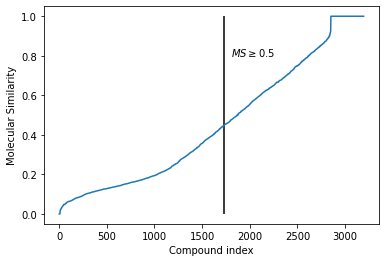

In [49]:
plt.plot(dfcomp[4], dfcomp[3])
plt.vlines(1733, 0, 1, color='black')
plt.text(1800, 0.8, '$MS\geq 0.5$')
plt.xlabel('Compound index')
plt.ylabel('Molecular Similarity')

In [50]:
with PdfPages('osra_benchmarking.pdf') as pdf:
    plt.plot(dfcomp[4], dfcomp[3])
    plt.vlines(1733, 0, 1, color='black')
    plt.text(1800, 0.8, '$MS\geq 0.5$')
    plt.xlabel('Compound index')
    plt.ylabel('Molecular Similarity')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

In [51]:
# Show similarity of true vs recovered structure 
# for various levels of molecular similarity
dfcomp[dfcomp[3].round(1)==0.6].head()

,level_0,index,0,1,2,3,4
1991,1991,1825,571,C[C@@H]1CC(=C[C@@H](C1(COC(=O)Nc1ccccc1)COC(=O...,*C(CCCC1=CCC(CC1)(COC(=O)Nc1ccccc1)COC(=O)Nc1c...,0.550388,1992
1992,1992,2871,890,C[NH2+]CC(=O)N[C@H]1CCN2[C@@H](C1)C(=O)Nc1ccc(...,[Hf]Oc1ccc(cc1c1ccc2c(c1)C(=O)N1CCC(NC1C(=O)N2...,0.551402,1993
1993,1993,1878,597,Cc1ccc(cc1)[C@H]([C@@H]1CCCCC1=C)O,C=C1CCCC[C@H]1C(=C)c1ccc(cc1)C,0.551724,1994
1994,1994,481,128,CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)OC[C@@H](CO[C@@...,*CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)OC[C@@H](COC1C...,0.552000,1995
1995,1995,2180,678,c1(c(c(c(c(c1OC)C)OC)C)OC)C(=O)CC(C)C,COc1c(C(=O)CC(I)C)c(OI)c(c(c1C)OC)I,0.552239,1996


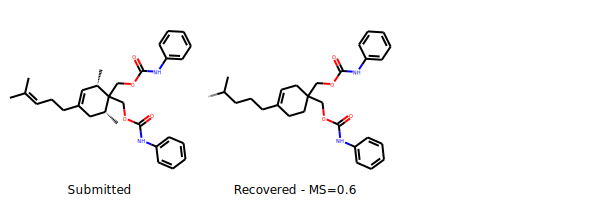

In [67]:
plot_panel(dfcomp.loc[1991, [1, 2]].tolist(), 
           legends=['Submitted', 'Recovered - MS=0.6'], useSVG=True)

In [60]:
dfcomp[dfcomp[3].round(1)==0.7].head()

,level_0,index,0,1,2,3,4
2251,2251,2486,759,[C@]1(OC(=O)[C@@]2(C[C@@H]([C@H]([C@H](C2)O)O)...,O=CC1CC(C)(C[C@@H](C1C)OC(=O)/C=C/c1ccc(c(c1)O...,0.650307,2252
2252,2252,196,55,CCC(=O)N(CC[C@@H](c1ccc(cc1)OC(C)C)c1ccccc1OC)...,CCC(=O)N(Cc1ccc(c(c1)OC)OC)C/*=C(/c1ccccc1OC)\...,0.650794,2253
2253,2253,2362,725,[C@@H](C(=O)O)(CCC(=O)NCCO)N,OCCNC(=O)CC[C@@H](C(=O)O)C*,0.651163,2254
2254,2254,1440,469,Cc1cc(ccc1OC)C(=O)C1=C(C(=O)N([C@@H]1c1ccc(c(c...,COc1cc(ccc1OC)[C@H]1N(CC*([Hf])C)C(=O)C(=C1C(=...,0.651376,2255
2255,2255,1843,576,C[C@]12C[C@@H]([C@@H]([C@H]([C@@H]1C(=O)CC[C@H...,OCC(=C)C(=C)C(=O)O[C@H]1C[C@]2(C)[C@H](*)CCC(=...,0.652174,2256


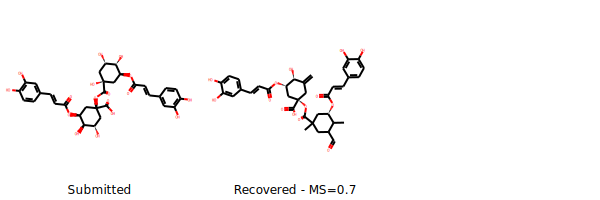

In [69]:
plot_panel(dfcomp.loc[2251, [1, 2]].tolist(),
          legends=['Submitted', 'Recovered - MS=0.7'], useSVG=True)

In [62]:
dfcomp[dfcomp[3].round(1)==0.8].head()

,level_0,index,0,1,2,3,4
2494,2494,1620,513,CCCCc1cc(=O)oc2c1ccc(c2C)OC(=O)[C@H](CC)NS(=O)...,CCCCc1cc(=O)oc2c1ccc(c2C)OC(=O)/C(=C/C)/NS(=O)...,0.75,2495
2495,2495,390,107,[C@@]12([C@@H]([C@H]3[C@@H]([C@@]4(C(=CC3)C=CC...,CC1CCC2(OC1)OC1C(C2C)[C@@]2([C@H](C1C)[C@@H]1C...,0.75,2496
2496,2496,604,178,c12c(=O)c(c3ccc(cc3)O)coc1cc(cc2)O[C@H]([C@@H]...,Oc1ccc(cc1)c1coc2c(c1=O)ccc(c2)O[C@H](C(=O)C(=...,0.75,2497
2497,2497,3185,998,COC(=O)c1cc2ccc(cc2oc1=O)O,C=*OC(=O)c1cc2ccc(cc2oc1=O)O,0.75,2498
2498,2498,1465,476,Cc1c(oc2c1cc1c(c(c(=O)oc1c2)CC(=O)NCCc1ccc(cc1...,O=C(Cc1c(=O)oc2c(c1[Hf])cc1c(c2)oc(c1[Hf])C)NC...,0.75,2499


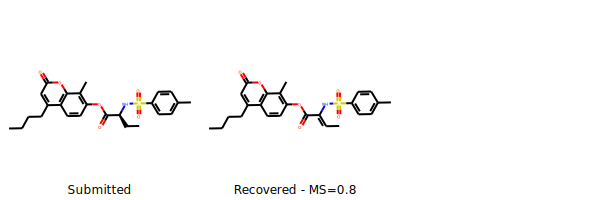

In [71]:
plot_panel(dfcomp.loc[2494, [1, 2]].tolist(),
          legends=['Submitted', 'Recovered - MS=0.8'], useSVG=True)

In [64]:
dfcomp[dfcomp[3].round(1)==0.9].head()

,level_0,index,0,1,2,3,4
2739,2739,2177,678,c1(c(c(c(c(c1OC(=O)/C(=C\C)/C)O)OC)O)C(=O)/C=C...,N=[I]/C=C(\C(=O)Oc1c(OC)c(C(=O)/C=C/c2ccccc2)c...,0.850575,2740
2740,2740,647,188,Cn1cc(c2c1ccc(c2)OC)/C=C\1/C(=O)c2ccc(cc2O1)OC...,[I]=NC(=O)COc1ccc2c(c1)O/C(=C\c1cn(c3c1cc(OC)c...,0.850575,2741
2741,2741,2152,671,Cn1c2ccc(cc2c(=O)c(c1c1ccccc1)OC)OC,COc1c(c2ccccc2)n(C)c2c(c1=O)cc(cc2)O*,0.850746,2742
2742,2742,2318,713,CCCOC(=O)CSc1cncc(n1)SCC(=O)OCCC,CCCOC(=O)CSc1cncc(n1)SCC(=O)OCC[Hf],0.850746,2743
2743,2743,796,243,c1(c2c(cc3c1C(=O)C[C@@H](C3)O)cc(c(c2C)C(=O)OC...,*OC(=O)c1c(O)cc2c(c1C)c(O)c1c(c2)CC(CC1=O)O,0.850746,2744


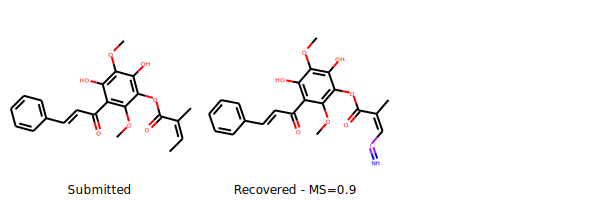

In [72]:
plot_panel(dfcomp.loc[2739, [1, 2]].tolist(),
          legends=['Submitted', 'Recovered - MS=0.9'], useSVG=True)

In [86]:
strc = dfcomp.loc[1991, [1, 2]].tolist()+dfcomp.loc[2251, [1, 2]].tolist()+dfcomp.loc[2494, [1, 2]].tolist()+dfcomp.loc[2739, [1, 2]].tolist()
img = plot_panel(strc, 
                 legends=['Submitted', 'Recovered - MS=0.6',
                         'Submitted', 'Recovered - MS=0.7',
                         'Submitted', 'Recovered - MS=0.8',
                         'Submitted', 'Recovered - MS=0.9'], 
                 useSVG=True)
    
with open('osra_recovered_examples.svg', 'w+') as f:
    f.write(img.data)

In [87]:
# Load oscar results
oscar = pd.read_csv('oscar_name.tsv', sep='\t')
oscar.head()

,name,standardInChI,standardInChIKey,doi,ExactMolWt
0,diazoaminobenzene,InChI=1S/C12H11N3/c1-3-7-11(8-4-1)13-15-14-12-...,ALIFPGGMJDWMJH-UHFFFAOYSA-N,final-302.json,197.095297
1,anisole,"InChI=1S/C7H8O/c1-8-7-5-3-2-4-6-7/h2-6H,1H3",RDOXTESZEPMUJZ-UHFFFAOYSA-N,final-302.json,108.057515
2,iodol,InChI=1S/C4H5I/c1-2-4-5-3-1/h1-5H,OMYXFRGZYJDEPI-UHFFFAOYSA-N,final-302.json,179.943598
3,"2,4-bis(chloromethyl)-3,5-dimethylbicyclo[4.2....",InChI=1S/C12H14Cl2/c1-7-9-3-4-10(9)12(6-14)8(2...,VOQZCIGSIKSGAL-UHFFFAOYSA-N,final-302.json,228.047256
4,Dioxane,InChI=1S/C4H8O2/c1-2-6-4-3-5-1/h1-4H2,RYHBNJHYFVUHQT-UHFFFAOYSA-N,final-302.json,88.052429


In [88]:
oscar.shape

(20490, 5)

In [89]:
oscar['doi'] = oscar['doi'].str.replace('\\D', '')
oscar.head()

,name,standardInChI,standardInChIKey,doi,ExactMolWt
0,diazoaminobenzene,InChI=1S/C12H11N3/c1-3-7-11(8-4-1)13-15-14-12-...,ALIFPGGMJDWMJH-UHFFFAOYSA-N,302,197.095297
1,anisole,"InChI=1S/C7H8O/c1-8-7-5-3-2-4-6-7/h2-6H,1H3",RDOXTESZEPMUJZ-UHFFFAOYSA-N,302,108.057515
2,iodol,InChI=1S/C4H5I/c1-2-4-5-3-1/h1-5H,OMYXFRGZYJDEPI-UHFFFAOYSA-N,302,179.943598
3,"2,4-bis(chloromethyl)-3,5-dimethylbicyclo[4.2....",InChI=1S/C12H14Cl2/c1-7-9-3-4-10(9)12(6-14)8(2...,VOQZCIGSIKSGAL-UHFFFAOYSA-N,302,228.047256
4,Dioxane,InChI=1S/C4H8O2/c1-2-6-4-3-5-1/h1-4H2,RYHBNJHYFVUHQT-UHFFFAOYSA-N,302,88.052429


In [90]:
# Load input reagents
reag = pd.read_csv('/home/rsilva/Documents/npmine_library/data/reagentes.tsv', 
                   sep='\t')
reag.head()

,Reagent,InChIKey
0,"1,1,1-Trichloroethane",UOCLXMDMGBRAIB-UHFFFAOYSA-N
1,"1,1,2,2-Tetrachloroethane",QPFMBZIOSGYJDE-UHFFFAOYSA-N
2,"1,2-Dichloroethane",WSLDOOZREJYCGB-UHFFFAOYSA-N
3,"1,3-Benzenediol",LUKBXSAWLPMMSZ-UHFFFAOYSA-N
4,1-Butanol,LRHPLDYGYMQRHN-UHFFFAOYSA-N


In [92]:
# Load input english dictionaries
english_dict = pd.read_csv('/home/rsilva/Documents/npmine_library/data/words_alpha.txt', header=None)
english_dict[0] = english_dict[0].str.lower()
english_dict.head()

,0
0,a
1,aa
2,aaa
3,aah
4,aahed


In [93]:
# Compare input with recovered names
nms_counts = []
recov_counts = []
submit_counts = []

reag_low = reag['Reagent'].str.lower()

for i in range(1000):
    nms = struct[i]['names']
    nms = [x.lower() for x in nms]
    nms = [re.sub('^ | $', '', x) for x in nms]
    recov = oscar.loc[oscar['doi']==str(i), 'name']
    recov_counts.append(len(recov))
    
    nrecov = recov.str.lower().isin(nms).sum()
    nms_counts.append(nrecov)
    submit_counts.append(len(nms))

In [94]:
names = pd.DataFrame([nms_counts, recov_counts, submit_counts]).T
names[3] = names[0]/names[1]
names[4] = names[0]/names[2]

names.sort_values(4, inplace=True)
names.reset_index(inplace=True)
names.head()

,index,0,1,2,3,4
0,971,0,10,1,0.0,0.0
1,431,0,11,9,0.0,0.0
2,259,0,7,6,0.0,0.0
3,858,0,29,9,0.0,0.0
4,461,0,10,11,0.0,0.0


In [99]:
# Proportion of recoved names by document
names[names[4].round(1)==0.5].head()

,index,0,1,2,3,4
234,511,5,9,11,0.555556,0.454545
235,166,10,28,22,0.357143,0.454545
236,381,5,13,11,0.384615,0.454545
237,639,5,19,11,0.263158,0.454545
238,260,5,21,11,0.238095,0.454545


Text(0, 0.5, 'Proportion of recoved names')

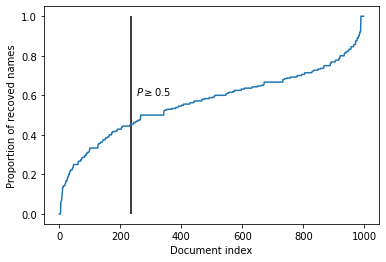

In [100]:
# NOTE: Thus the cumulative distribution functions for many common probability distributions are sigmoidal
names.sort_values(4, inplace=True)
plt.plot(range(1000), names[4])
plt.vlines(234, 0, 1, color='black')
plt.text(250, 0.6, '$P \geq 0.5$')
plt.xlabel('Document index')
plt.ylabel('Proportion of recoved names')

In [101]:
with PdfPages('oscar_benchmarking.pdf') as pdf:
    plt.plot(range(1000), names[4])
    plt.vlines(234, 0, 1, color='black')
    plt.text(250, 0.6, '$P \geq 0.5$')
    plt.xlabel('Document index')
    plt.ylabel('Proportion of recoved names')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

In [102]:
# Load gnfinder results
species = pd.read_csv('gn_dataframe.tsv', sep='\t')
species['doi'] = species['doi'].str.replace('\\D', '')
species.head()

,doi,verbatim,odds,dataSourceId,taxonId,classificationPath,classificationRank,matchType
0,925,Chryseobacterium lineare,3.609182e+11,4.0,1859201,|Bacteria|||Bacteroidetes|Flavobacteriia|Flavo...,|superkingdom|||phylum|class|order|family|genu...,ExactMatch
1,925,Cecidomyiidae,1.069498e+05,1.0,3946216,Animalia|Arthropoda|Insecta|Diptera|Cecidomyiidae,kingdom|phylum|class|order|family,ExactMatch
2,925,An-\nthomyiidae,8.695090e+04,1.0,3946232,Animalia|Arthropoda|Insecta|Diptera|Anthomyiidae,kingdom|phylum|class|order|family,ExactMatch
3,925,Banchopsis,1.274615e+05,1.0,3981772,Animalia|Arthropoda|Insecta|Hymenoptera|Ichneu...,kingdom|phylum|class|order|superfamily|family|...,ExactMatch
4,925,Symphygas nephaula,7.160308e+10,1.0,793397,Animalia|Arthropoda|Insecta|Lepidoptera|Tortri...,kingdom|phylum|class|order|superfamily|family|...,ExactCanonicalMatch


In [117]:
# Count the number of scientific names recovered
# and names recoverd until genera level
spc_counts = []
all_recov = []
all_spc = []
all_genera = []

for i in range(1000):
    spc = struct[i]['species']
    spc = [x.lower() for x in spc]
    spc = [re.sub('^ | $', '', x) for x in spc]
    recov = species.loc[species['doi']==str(i), 'verbatim']
    all_spc.append(len(spc))
    all_recov.append(len(recov))
    gen = [x.split()[0] for x in recov.str.lower()]
    all_genera.append(sum([x.split()[0] in gen for x in spc]))
    
    nrecov = recov.str.lower().isin(spc).sum()
    spc_counts.append(nrecov)

In [118]:
spdf = pd.DataFrame([spc_counts, all_genera, all_spc]).T
spdf[3] = spdf[0]/spdf[2]
spdf[4] = spdf[1]/spdf[2]

spdf.sort_values(3, inplace=True)
spdf.reset_index(inplace=True)
spdf.head()

,index,0,1,2,3,4
0,96,0,6,8,0.0,0.750000
1,448,0,6,14,0.0,0.428571
2,155,0,6,8,0.0,0.750000
3,188,0,4,16,0.0,0.250000
4,508,0,4,14,0.0,0.285714


In [114]:
spdf.sort_values(4).reset_index()[spdf.sort_values(4).reset_index()[4].round(1)==0.5].head()

,level_0,index,0,1,2,3,4
37,44,6,3,10,22,0.136364,0.454545
38,75,887,4,11,24,0.166667,0.458333
39,81,653,2,6,12,0.166667,0.500000
40,114,507,3,8,16,0.187500,0.500000
41,158,927,3,7,14,0.214286,0.500000


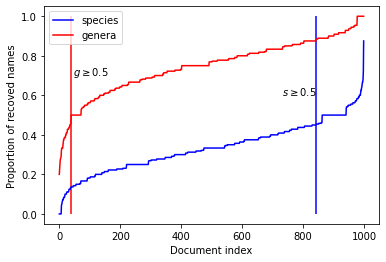

In [115]:
plt.plot(range(1000), spdf[3], color='blue', label='species')

spdf.sort_values(4, inplace=True)
plt.plot(range(1000), spdf[4], color='red', label='genera')

plt.vlines(843, 0, 1, color='blue')
plt.vlines(37, 0, 1, color='red')

plt.text(730, 0.6, '$s \geq 0.5$')
plt.text(45, 0.7, '$g \geq 0.5$')

plt.xlabel('Document index')
plt.ylabel('Proportion of recoved names')
plt.legend()

In [116]:
spdf.reset_index(drop=True, inplace=True)
spdf[spdf[4].round(1)==0.5].head()

,index,0,1,2,3,4
37,6,3,10,22,0.136364,0.454545
38,887,4,11,24,0.166667,0.458333
39,653,2,6,12,0.166667,0.500000
40,507,3,8,16,0.187500,0.500000
41,927,3,7,14,0.214286,0.500000


In [119]:
with PdfPages('gnfinder_benchmarking.pdf') as pdf:
    plt.plot(range(1000), spdf[3], color='blue', label='species')

    spdf.sort_values(4, inplace=True)
    plt.plot(range(1000), spdf[4], color='red', label='genera')

    plt.vlines(843, 0, 1, color='blue')
    plt.vlines(37, 0, 1, color='red')

    plt.text(730, 0.6, '$s \geq 0.5$')
    plt.text(45, 0.7, '$g \geq 0.5$')

    plt.xlabel('Document index')
    plt.ylabel('Proportion of recoved names')
    plt.legend()
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()